# Code for all ML models used and Data exploration
##### Author: Greg Bodik

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import clone
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from yellowbrick.regressor import residuals_plot
from sklearn import tree
from sklearn.metrics import confusion_matrix

C:\Users\gergo\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
#'df_all' is the master df with the full dataset
df_all = pd.read_csv('movie_metadata.csv')
#df is the dataset containing the normalized features for US movies only
df = pd.read_csv('features_norm_withCR.csv')
#'df_dummies' is the dataset containing the normalized features for US movies only with dummy variabes for content_rating
df_dummies = pd.read_csv('features_norm_CRdummies.csv')
df_dummies.drop([df_dummies.columns[0]], axis=1,inplace=True)
#The 'newFilms' df contains data only for films with title_year >= 2010
newFilms = pd.read_csv('onlyNewFilmsNormAll.csv')
newFilms.drop([newFilms.columns[0]], axis=1,inplace=True)
newFilmsCR = pd.read_csv('newFilmsCRnoDummies.csv')

In [3]:
#Making a new datafram that contains all of the original unscaled features, but only for US films
i = 0
notUS = []
for i in range(0,len(df_all)):
    if (df_all.iloc[i]['country']!= 'USA'):
        notUS.append(i)
print(len(notUS))
print(len(df_all))
df_all_onlyUS = df_all.drop(df_all.index[notUS])

1236
5043


In [4]:
#finding which rows have movie ratings to exclude (df already contains only US films with scaled features)
i = 0
toRemove = []
for i in range(0,len(df)):
    if (df.iloc[i]['content_rating'] != 'PG' and df.iloc[i]['content_rating']!= 'PG-13' and df.iloc[i]['content_rating']!='G' and df.iloc[i]['content_rating']!= 'R'):
        toRemove.append(i)
    
print(len(toRemove))
print(len(df))
df_only4CR = df.drop(df.index[toRemove])
df_only4CR.drop([df_only4CR.columns[0]],axis=1,inplace=True)
#df_only4CR=df_only4CR.drop([df_only4CR.columns[0]], axis=1,inplace=True)

385
3807


In [5]:
#finding which rows have movie ratings to exclude from newFilms CR data(df already contains only US films with scaled features)
i = 0
toRemove = []
for i in range(0,len(newFilmsCR)):
    if (newFilmsCR.iloc[i]['content_rating'] != 'PG' and newFilmsCR.iloc[i]['content_rating']!= 'PG-13' and newFilmsCR.iloc[i]['content_rating']!='G' and newFilmsCR.iloc[i]['content_rating']!= 'R'):
        toRemove.append(i)
    
print(len(toRemove))
print(len(newFilmsCR))
df_newF_only4CR = newFilmsCR.drop(newFilms.index[toRemove])

256
2734


In [6]:
#dropping un need columns and checking how the df looks. 
df_newF_only4CR.drop([df_newF_only4CR.columns[0]],axis=1,inplace=True)
df_newF_only4CR.head(10)

movie_title  imdb_score_scaled  \
0                                      Avatar            1.468202   
1    Pirates of the Caribbean: At World's End            0.757386   
2                       The Dark Knight Rises            2.001313   
3                                 John Carter            0.313127   
4                                Spider-Man 3           -0.042281   
5                                     Tangled            1.379350   
6                     Avengers: Age of Ultron            1.112794   
7          Batman v Superman: Dawn of Justice            0.579682   
8                            Superman Returns           -0.131133   
9  Pirates of the Caribbean: Dead Man's Chest            0.935090   

   budget_scaled  num_voted_users_scaled  movie_facebook_likes_scaled  \
0       4.169934                5.744872                     1.005535   
1       5.508576                2.747844                    -0.434162   
2       4.446162                7.609118                     6.720695   
3       4.737264                0.877221                     0.612890   
4       4.616148                2.111120                    -0.434162   
5       4.658645                1.473805                     0.831026   
6       4.446162                2.686088                     4.713845   
7       4.446162                2.028666                     8.160392   
8       3.574982                1.080825                    -0.434162   
9       3.914955                3.114868                    -0.216026   

   cast_total_facebook_likes_scaled  num_critic_for_reviews_scaled  \
0                         -0.316193                       4.168528   
1                          1.628521                       1.014523   
2                          4.238798                       4.842781   
3                         -0.448519                       2.213195   
4                          1.525958                       1.688776   
5                         -0.441235                       1.179340   
6                          3.579224                       3.509258   
7                          0.560439                       3.793943   
8                          0.808064                       2.003427   
9                          1.634599                       1.096931   

   gross_scaled content_rating  
0      9.512799          PG-13  
1      3.422053          PG-13  
2      5.295129          PG-13  
3      0.230931          PG-13  
4      3.788308          PG-13  
5      1.955784             PG  
6      5.441773          PG-13  
7      3.703499          PG-13  
8      1.945822          PG-13  
9      4.956257          PG-13

In [7]:
#generating the content rating boxplot we use in the presentation/writeup
fig = px.box(df_all_onlyUS, x="content_rating", y="gross",title="Gross Earnings by Content Rating")
fig.show()

In [8]:
#Distribution of gross revenues for only US films
fig = px.histogram(df_all_onlyUS, x="gross",title="Distribution of movie revenues for US films only")
fig.show()
#Getting summary stats for revenues distribution
df_all_onlyUS['gross'].describe()

count    3.235000e+03
mean     5.521461e+07
std      7.173312e+07
min      7.030000e+02
25%      1.011027e+07
50%      3.217878e+07
75%      7.214700e+07
max      7.605058e+08
Name: gross, dtype: float64

In [9]:
#Revenue distributions boxplots of all US films for a particular title year
fig = px.box(df_all_onlyUS, x="title_year", y="gross",title="Gross Revenue Distributions by Title year of Film")
fig.show()

In [10]:
#An example of how we selected features by looking at the relations between variables. 
fig = px.scatter(df_all_onlyUS, x="num_voted_users", y="gross", title = "Relation between gross revenue and number of IMDb Ratings")
fig.show()

In [11]:
X = df_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y)
#X.fillna(X.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
#x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2)

# This is the function we use to create the kNN model (default k=5)
model = RandomForestClassifier(50)

# TODO fit the model using the train data
model.fit(X_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(X_test)
print("sklearn's accuracy score for predict movie content rating:", accuracy_score(y_test, predictions))
labels = ['','','','']
#plotCM(model)

sklearn's accuracy score for predict movie content rating: 0.6226635514018691


In [12]:
def plotCM(fitted_model, X_test = X_test, y_test = y_test):
    """
    plots confusion matrix for given model
    """
    disp = plot_confusion_matrix(fitted_model, X_test, y_test,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize="true")
    disp.ax_.set_title("Normalized confusion matrix")

    print("Normalized confusion matrix")
    print(disp.confusion_matrix)

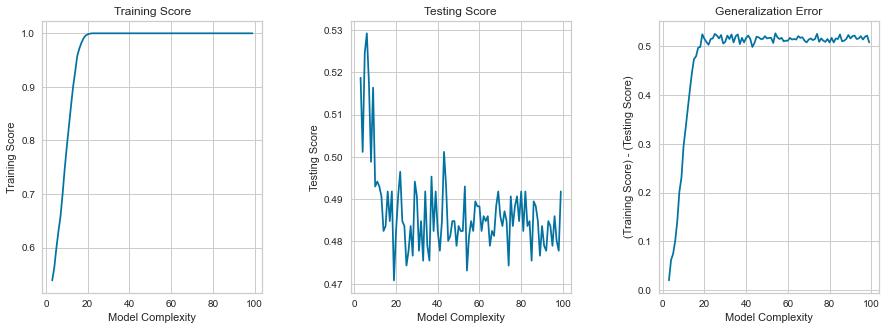

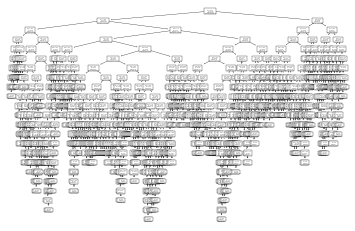

In [13]:
X = df_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y)

max_depths = list(range(3,100))
train_scores = []
test_scores = []
for i in max_depths:
    model = DecisionTreeClassifier(max_depth=i)

    model.fit(X_train, y_train)
    
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    
plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()
tree.plot_tree(model);

training score: 0.5697583787996883
validation score: 0.5245327102803738


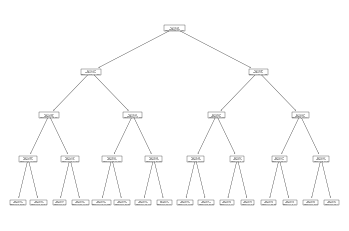

In [14]:
X = df_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y)
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)
print("training score:", model.score(X_train,y_train)) # how accurately did model capture training set relationship?
print("validation score:", model.score(X_test,y_test)) # how well can model predict new things?
tree.plot_tree(model);


Feature ranking:
1. feature 9 (0.109647)
2. feature 10 (0.090183)
3. feature 1 (0.075464)
4. feature 0 (0.075303)
5. feature 12 (0.070950)
6. feature 8 (0.069822)
7. feature 5 (0.067067)
8. feature 3 (0.060701)
9. feature 2 (0.058840)
10. feature 11 (0.057698)
11. feature 6 (0.056631)
12. feature 4 (0.056481)
13. feature 14 (0.052559)
14. feature 13 (0.049428)
15. feature 7 (0.049227)


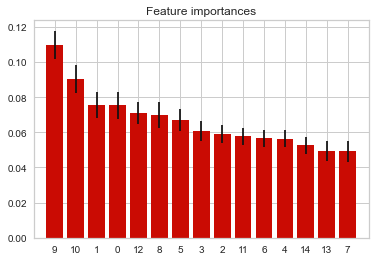

In [15]:
#Messing around with feature selection using trees. Conclusion: Inconclusive/NA

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df_all_onlyUS.select_dtypes(include=numerics).drop(['gross'],axis=1)
X.fillna(X.mean(),inplace=True)
y = df_all_onlyUS['content_rating']
y.fillna('',inplace=True)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
#Linear Regression using all possible features
X = df_dummies.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train)) 
print("validation score:", model.score(x_test,y_test)) 

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

training score: 0.576672515145628
validation score: 0.5306200739548832


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_scaled   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     220.5
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        18:00:53   Log-Likelihood:                -3473.4
No. Observations:                3807   AIC:                             6995.
Df Residuals:                    3783   BIC:                             7145.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
imdb_score_scaled                   -0.0223      0.012     -1.930      0.054      -0.045       0.000
budget_scaled                        0.3769      0.013     28.597      0.000       0.351       0.403
num_voted_users_scaled               0.4445      0.014     31.843      0.000       0.417       0.472
movie_facebook_likes_scaled         -0.0054      0.014     -0.389      0.698      -0.033       0.022
cast_total_facebook_likes_scaled     0.0098      0.010      0.950      0.342      -0.010       0.030
num_critic_for_reviews_scaled        0.0085      0.017      0.510      0.610      -0.024       0.041
Approved                             0.4797      0.090      5.312      0.000       0.303       0.657
G                                    0.3492      0.066      5.290      0.000       0.220       0.479
GP                                   0.4065      0.303      1.344      0.179      -0.187       1.000
M                                    0.6034      0.349      1.728      0.084      -0.081       1.288
NC-17                               -0.1346      0.271     -0.498      0.619      -0.665       0.396
Not Rated                            0.1418      0.085      1.665      0.096      -0.025       0.309
PG                                   0.2127      0.026      8.142      0.000       0.161       0.264
PG-13                               -0.0080      0.018     -0.443      0.658      -0.043       0.027
Passed                               0.2769      0.202      1.370      0.171      -0.119       0.673
R                                   -0.1589      0.016    -10.057      0.000      -0.190      -0.128
TV-14                                0.2003      0.122      1.637      0.102      -0.040       0.440
TV-G                                 0.4029      0.214      1.882      0.060      -0.017       0.823
TV-MA                                0.0597      0.176      0.338      0.735      -0.286       0.405
TV-PG                                0.2958      0.169      1.755      0.079      -0.035       0.626
TV-Y7                                0.2315      0.605      0.383      0.702      -0.954       1.417
Unrated                              0.1861      0.099      1.885      0.059      -0.007       0.380
X                                    0.0203      0.175      0.116      0.907      -0.322       0.363
unknown                              0.3548      0.049      7.211      0.000       0.258       0.451
==============================================================================
Omnibus:                     1617.294   Durbin-Watson:                   1.565
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29566.547
Skew:                           1.556   Prob(JB):                         0.00
Kurtosis:                      16.293   

In [17]:
#Linear Regression with Approved GP M NC-17 Not Rated  Passed TV-14 TV-G TV-MA TV-PG TV-Y7 Unrated X unknown Removed
#CONCLUSION: slightly less overfitting
X = df_dummies.drop(['movie_title','gross_scaled','Approved','GP','M','NC-17','Not Rated','Passed','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','X','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train)) 
print("validation score:", model.score(x_test,y_test)) 


model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()


training score: 0.5741839304299703
validation score: 0.5313455598737142


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_scaled   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     486.8
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        18:00:53   Log-Likelihood:                -3521.4
No. Observations:                3807   AIC:                             7063.
Df Residuals:                    3797   BIC:                             7125.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
imdb_score_scaled                   -0.0038      0.011     -0.335      0.738      -0.026       0.018
budget_scaled                        0.3725      0.013     28.158      0.000       0.347       0.398
num_voted_users_scaled               0.4360      0.014     30.999      0.000       0.408       0.464
movie_facebook_likes_scaled          0.0068      0.014      0.487      0.626      -0.021       0.034
cast_total_facebook_likes_scaled     0.0061      0.010      0.586      0.558      -0.014       0.027
num_critic_for_reviews_scaled       -0.0220      0.016     -1.353      0.176      -0.054       0.010
G                                    0.3409      0.067      5.111      0.000       0.210       0.472
PG                                   0.2112      0.026      8.002      0.000       0.159       0.263
PG-13                                0.0039      0.018      0.215      0.830      -0.032       0.040
R                                   -0.1593      0.016     -9.981      0.000      -0.191      -0.128
==============================================================================
Omnibus:                     1586.253   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27786.062
Skew:                           1.528   Prob(JB):                         0.00
Kurtosis:                      15.877   Cond. No.                         11.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
#Removing num_critic_for_reviews (seems least correlated)
#Conclusion: Very slightly better?
X = df_dummies.drop(['num_critic_for_reviews_scaled','movie_title','gross_scaled','Approved','GP','M','NC-17','Not Rated','Passed','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','X','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train)) 
print("validation score:", model.score(x_test,y_test)) 

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

training score: 0.5740710265408023
validation score: 0.5322462584480419


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_scaled   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     540.6
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        18:00:53   Log-Likelihood:                -3522.3
No. Observations:                3807   AIC:                             7063.
Df Residuals:                    3798   BIC:                             7119.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
imdb_score_scaled                   -0.0054      0.011     -0.480      0.631      -0.028       0.017
budget_scaled                        0.3664      0.012     29.460      0.000       0.342       0.391
num_voted_users_scaled               0.4311      0.014     31.703      0.000       0.404       0.458
movie_facebook_likes_scaled         -0.0029      0.012     -0.242      0.809      -0.026       0.021
cast_total_facebook_likes_scaled     0.0053      0.010      0.508      0.612      -0.015       0.026
G                                    0.3477      0.067      5.227      0.000       0.217       0.478
PG                                   0.2152      0.026      8.204      0.000       0.164       0.267
PG-13                                0.0029      0.018      0.162      0.871      -0.033       0.039
R                                   -0.1623      0.016    -10.269      0.000      -0.193      -0.131
==============================================================================
Omnibus:                     1594.804   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27260.259
Skew:                           1.547   Prob(JB):                         0.00
Kurtosis:                      15.739   Cond. No.                         9.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

training score: 0.5740670603264195
validation score: 0.5322766182994136
                            OLS Regression Results                            
Dep. Variable:           gross_scaled   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     608.3
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        18:00:53   Log-Likelihood:                -3522.3
No. Observations:                3807   AIC:                             7061.
Df Residuals:                    3799   BIC:                             7111.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

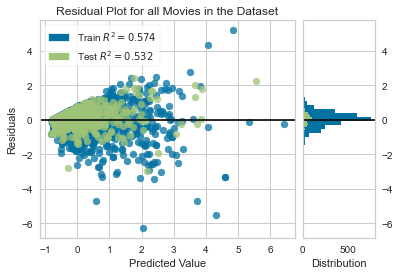

MSE:  0.2514703212589292


In [19]:
#Removing movie_facebook_likes (seems least correlated)
#Conclusion: Almost imperceivably better?
X = df_dummies.drop(['movie_facebook_likes_scaled','num_critic_for_reviews_scaled','movie_title','gross_scaled','Approved','GP','M','NC-17','Not Rated','Passed','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','X','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train)) 
print("validation score:", model.score(x_test,y_test)) 
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())
viz = residuals_plot(LinearRegression(), x_train, y_train, x_test, y_test,title='Residual Plot for all Movies in the Dataset')
viz.show()
predictions = model.predict(x_test)
print("MSE: ", mean_squared_error(y_test, predictions))

training score: 0.5675340334807124
validation score: 0.5242140892609383
                            OLS Regression Results                            
Dep. Variable:           gross_scaled   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     973.9
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        18:00:55   Log-Likelihood:                -3522.6
No. Observations:                3807   AIC:                             7055.
Df Residuals:                    3802   BIC:                             7086.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

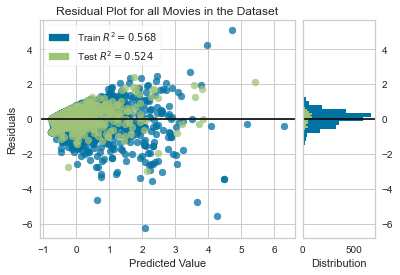

In [20]:
#Removing IMDb score, cast_total_facebook_likes_scaled, and PG-13 (seems least correlated)
#Conclusion: R^2 goes down. 
X = df_dummies.drop(['PG-13','imdb_score_scaled','cast_total_facebook_likes_scaled','movie_facebook_likes_scaled','num_critic_for_reviews_scaled','movie_title','gross_scaled','Approved','GP','M','NC-17','Not Rated','Passed','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','X','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train)) 
print("validation score:", model.score(x_test,y_test)) 
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())
viz = residuals_plot(LinearRegression(), x_train, y_train, x_test, y_test,title='Residual Plot for all Movies in the Dataset')
viz.show()

In [21]:
#Linear Regression using all possible features from newFilms df
#Conclusion: Using only films made after 2010 resulted in an immediate increase in model accuracy
X = newFilms.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train)) 
print("validation score:", model.score(x_test,y_test)) 

training score: 0.626579482096338
validation score: 0.6572037850501715


In [22]:
#Linear Regression on 'newFilms' with Approved GP M NC-17 Not Rated  Passed TV-14 TV-G TV-MA TV-PG TV-Y7 Unrated X unknown Removed
#CONCLUSION: about the same
X = newFilms.drop(['movie_title','gross_scaled','NC-17','Not Rated','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train))
print("validation score:", model.score(x_test,y_test)) 

training score: 0.6246258756002665
validation score: 0.6546112859051847


In [23]:
#Linear Regression on 'newFilms' now removing num_critic_for_reviews_scaled
#CONCLUSION: about the same
X = newFilms.drop(['num_critic_for_reviews_scaled','movie_title','gross_scaled','NC-17','Not Rated','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train)) 
print("validation score:", model.score(x_test,y_test)) 

training score: 0.6245537063031059
validation score: 0.654068477921403


training score: 0.624553625521617
validation score: 0.6540500380465527


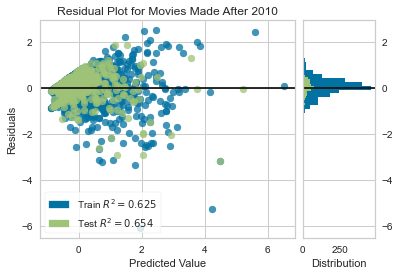

MSE:  0.2987381140021372


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_scaled   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     555.1
Date:                Sat, 23 May 2020   Prob (F-statistic):               0.00
Time:                        18:00:57   Log-Likelihood:                -2354.1
No. Observations:                2734   AIC:                             4724.
Df Residuals:                    2726   BIC:                             4771.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
imdb_score_scaled                   -0.0590      0.012     -4.781      0.000      -0.083      -0.035
budget_scaled                        0.3765      0.015     25.632      0.000       0.348       0.405
num_voted_users_scaled               0.4690      0.015     32.119      0.000       0.440       0.498
cast_total_facebook_likes_scaled     0.0045      0.011      0.389      0.697      -0.018       0.027
G                                    0.3168      0.082      3.850      0.000       0.155       0.478
PG                                   0.1869      0.031      6.111      0.000       0.127       0.247
PG-13                               -0.0088      0.018     -0.477      0.633      -0.045       0.027
R                                   -0.1488      0.018     -8.089      0.000      -0.185      -0.113
==============================================================================
Omnibus:                     1175.150   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17638.370
Skew:                           1.630   Prob(JB):                         0.00
Kurtosis:                      15.008   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
#Linear Regression on 'newFilms' now removing movie facebook likes
#CONCLUSION: about the same
X = newFilms.drop(['movie_facebook_likes_scaled','num_critic_for_reviews_scaled','movie_title','gross_scaled','NC-17','Not Rated','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)

# TODO train test split your data with 20% being used for testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

model = LinearRegression()

# TODO fit the model using the train data
model.fit(x_train,y_train)

# TODO store the predictions for the test sets
predictions = model.predict(x_test)
print("training score:", model.score(x_train,y_train))
print("validation score:", model.score(x_test,y_test)) 
from yellowbrick.regressor import residuals_plot
viz = residuals_plot(LinearRegression(), x_train, y_train, x_test, y_test,title='Residual Plot for Movies Made After 2010')
model = sm.OLS(y, X).fit()
predictions = model.predict(x_test)
print("MSE: ", mean_squared_error(y_test, predictions))
model.summary()

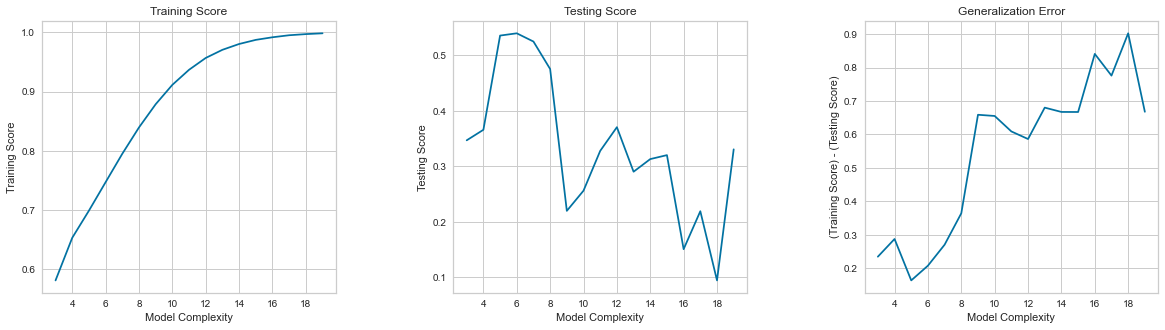

In [25]:
#Decision Tree Regressor to predict gross scaled
#CONCLUSION: seems to be around 8 levels deep
X = df_dummies.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

max_depths = list(range(3,20))
train_scores = []
test_scores = []
for i in max_depths:
    model = DecisionTreeRegressor(max_depth=i)

    model.fit(x_train, y_train)
    
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))
    
plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

In [26]:
#Decision Tree Regressor to predict gross scaled
#CONCLUSION: 'Best outcome is 7 levels deep'
X = df_dummies.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model = DecisionTreeRegressor(max_depth=7)
model.fit(x_train, y_train)
print("training score:", model.score(x_train,y_train)) # how accurately did model capture training set relationship?
print("validation score:", model.score(x_test,y_test)) # how well can model predict new things?

training score: 0.7952429691512454
validation score: 0.5247853375366365


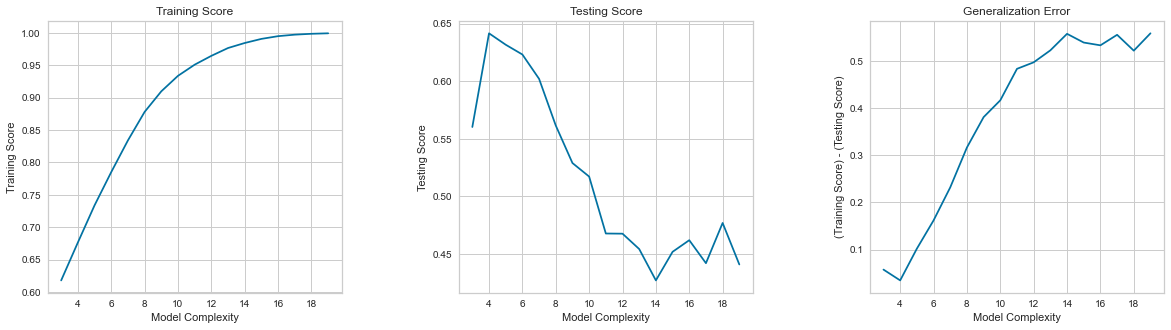

In [27]:
#Decision Tree Regressor to predict gross scaled from newFilms only
#CONCLUSION: 'Best' outcome is around 4 levels deep
X = newFilms.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

max_depths = list(range(3,20))
train_scores = []
test_scores = []
for i in max_depths:
    model = DecisionTreeRegressor(max_depth=i)

    model.fit(x_train, y_train)
    
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))
    
plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

In [28]:
#Decision Tree Regressor to predict gross scaled
#CONCLUSION: 'Best outcome is 4 levels deep'
X = newFilms.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model = DecisionTreeRegressor(max_depth=4)
model.fit(x_train, y_train)
print("training score:", model.score(x_train,y_train)) # how accurately did model capture training set relationship?
print("validation score:", model.score(x_test,y_test)) # how well can model predict new things?

training score: 0.676481869082191
validation score: 0.6415690023360332


In [29]:
#Random Forest Regressor to predict gross scaled
#CONCLUSION: 'Best outcome is 4 levels deep'
X = newFilms.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model = RandomForestRegressor(100,max_depth=3)
model.fit(x_train, y_train)
print("training score:", model.score(x_train,y_train)) # how accurately did model capture training set relationship?
print("validation score:", model.score(x_test,y_test)) # how well can model predict new things?

training score: 0.6585775877916091
validation score: 0.6376653456706468


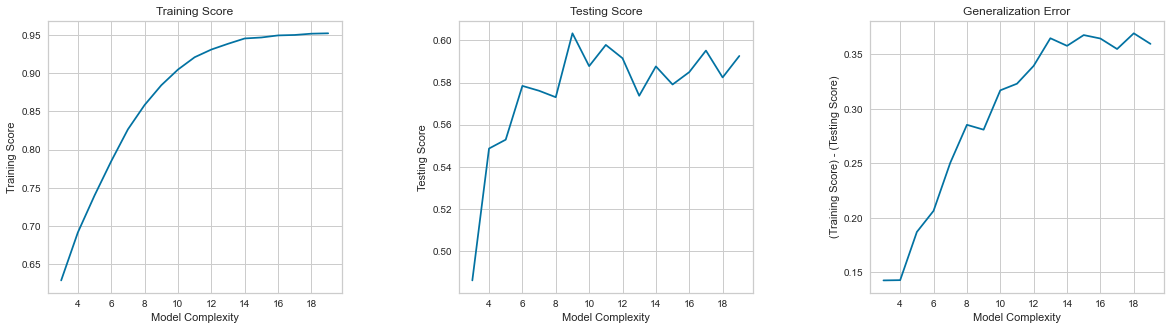

In [30]:
#RandomForestRegression to predict gross rev with 100 trees based on all Films
X = df_dummies.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
#Finding the best max_depth for FFR on gross rev
max_depths = list(range(3,20))
train_scores = []
test_scores = []
for i in max_depths:
    model = RandomForestRegressor(max_depth=i)

    model.fit(x_train, y_train)
    
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))
    
plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

In [31]:
#Checking MSE of random forest with max depth 8 on all movies data
X = df_dummies.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_dummies['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model = RandomForestRegressor(max_depth=8)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print("MSE: ", mean_squared_error(y_test, predictions))

MSE:  0.22634142887149464


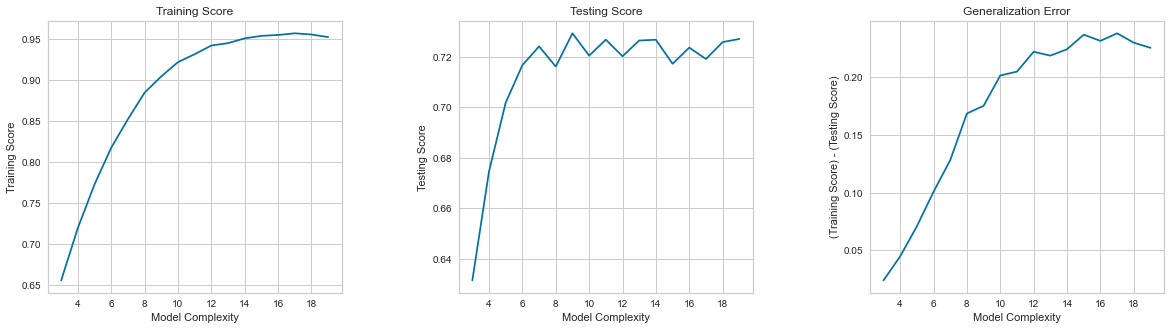

In [32]:
#RandomForestRegression to predict gross rev with 100 trees based on newFilms
X = newFilms.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
#Finding the best max_depth for FFR on gross rev
max_depths = list(range(3,20))
train_scores = []
test_scores = []
for i in max_depths:
    model = RandomForestRegressor(max_depth=i)

    model.fit(x_train, y_train)
    
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))
    
plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

In [33]:
#Checking MSE of random forest with max depth 8 on only new movies data
X = newFilms.drop(['movie_title','gross_scaled'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model = RandomForestRegressor(max_depth=7)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print("MSE: ", mean_squared_error(y_test, predictions))

MSE:  0.23069115826174225


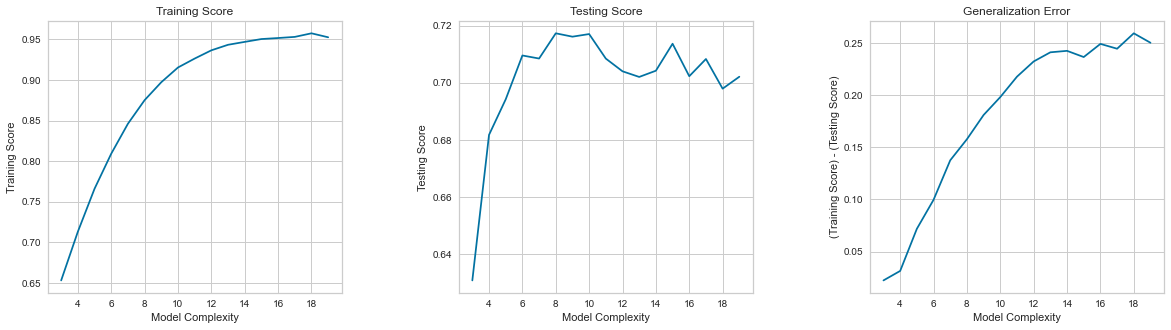

In [34]:
X = newFilms.drop(['movie_facebook_likes_scaled','num_critic_for_reviews_scaled','movie_title','gross_scaled','NC-17','Not Rated','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= newFilms['gross_scaled']
y.fillna(y.mean(),inplace=True)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
#Finding the best max_depth for FFR on gross rev
max_depths = list(range(3,20))
train_scores = []
test_scores = []
for i in max_depths:
    model = RandomForestRegressor(max_depth=i)

    model.fit(x_train, y_train)
    
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))
    
plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

In [35]:
# def rfr_model(X, y):
# # Perform Grid-Search
#     gsc = GridSearchCV(
#         estimator=RandomForestRegressor(),
#         param_grid={
#             'max_depth': range(3,7),
#             'n_estimators': (10, 50, 100),
#         },
#         cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
    
#     grid_result = gsc.fit(X, y)
#     best_params = grid_result.best_params_
    
#     rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
# # Perform K-Fold CV
#     scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

#     return scores

In [36]:
# DID NOT USE THIS OR THE METHOD ABOVE
# X = newFilms.drop(['movie_title','gross_scaled'],axis = 1)
# X.fillna(X.mean(),inplace=True)
# y= newFilms['gross_scaled']
# y.fillna(y.mean(),inplace=True)
# rfr_model(X,y)

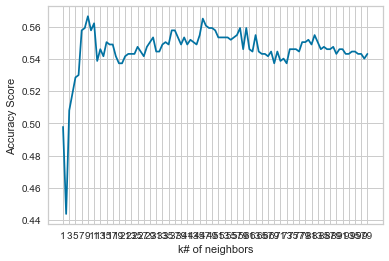

best accuracy:  0.5664233576642336
best num neighbors:  9


In [37]:
#Trying to determine best k for kNN on all films
X = df_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
best_depth = 1 #Keep track of depth that produces tree with highest accuracy
best_accuracy = 0 #The best accuracy from a given tree
klist = []
for k in range(1,100):
    model=KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    klist.append(accuracy_score(y_test, predictions))
    if (accuracy_score(y_test, predictions) > best_accuracy):
        best_accuracy = accuracy_score(y_test, predictions)
        best_k = k
    #Fill in code here
plt.plot(range(1,100), klist)
plt.xticks(range(1,100,2),range(1,100,2))
plt.xlabel("k# of neighbors")
plt.ylabel("Accuracy Score")
plt.show()  
print('best accuracy: ', best_accuracy)
print('best num neighbors: ', best_k)


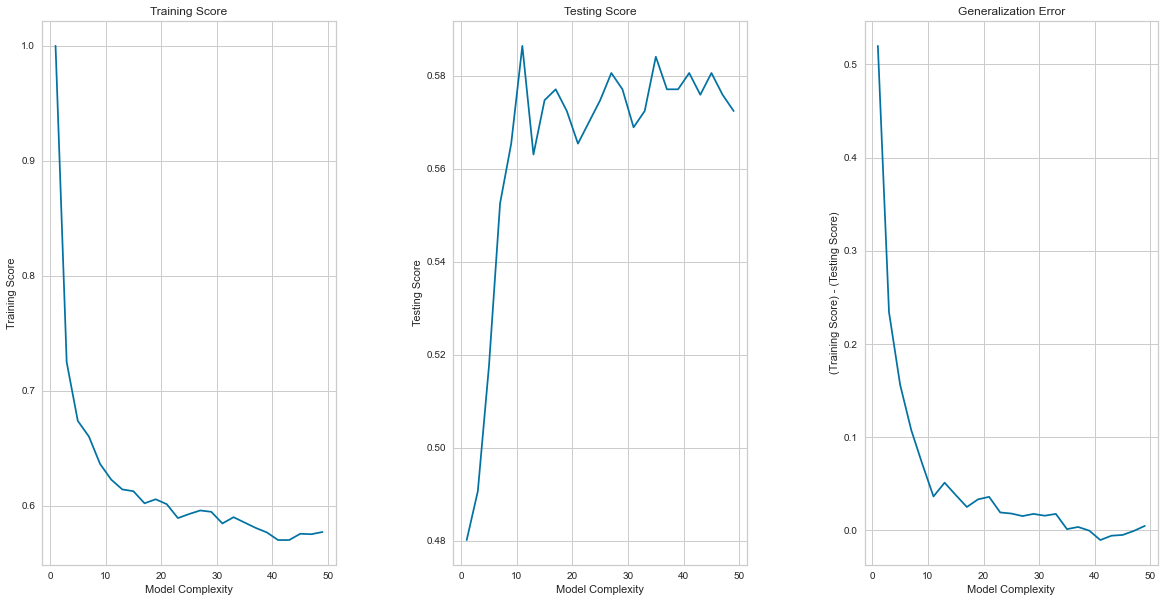

In [38]:
#Trying to detemrine a good k
X = df_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y)
max_depths = list(range(1,50,2))
train_scores = []
test_scores = []
for i in max_depths:
    model = KNeighborsClassifier(n_neighbors=i)

    model.fit(X_train, y_train)
    
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    
plt.subplots(figsize=(20,10))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

The optimal number of neighbors is 47


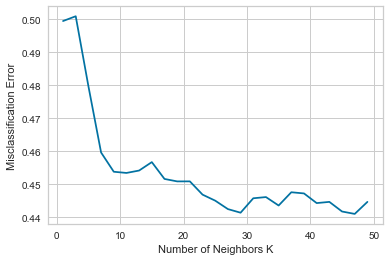

In [39]:
#Using 10fold CV to find optimal k for KNN on all films
X = df_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

[[  0   0   4  10]
 [  0   9  54  47]
 [  0   5 122 109]
 [  0   2  70 253]]
training score: 0.5820241139934235
validation score: 0.5605839416058395
confusion matrix from kNN (All Data)
[[  0   0   4  10]
 [  0   9  54  47]
 [  0   5 122 109]
 [  0   2  70 253]]


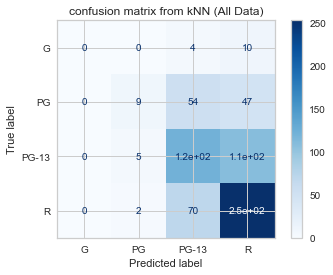

In [40]:
#Confusion matrix for KNN on all films) 
X = df_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model=KNeighborsClassifier(n_neighbors = 47)
model.fit(X_train,y_train)
predictions = model.predict(X_test)

matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix(y_test,predictions,labels = ['G','PG','PG-13','R']))
print("training score:", model.score(X_train,y_train)) # how accurately did model capture training set relationship?
print("validation score:", model.score(X_test,y_test))
classifier = model.fit(X_train,y_train)
disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['G','PG','PG-13','R'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
title = 'confusion matrix from kNN (All Data)'
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)




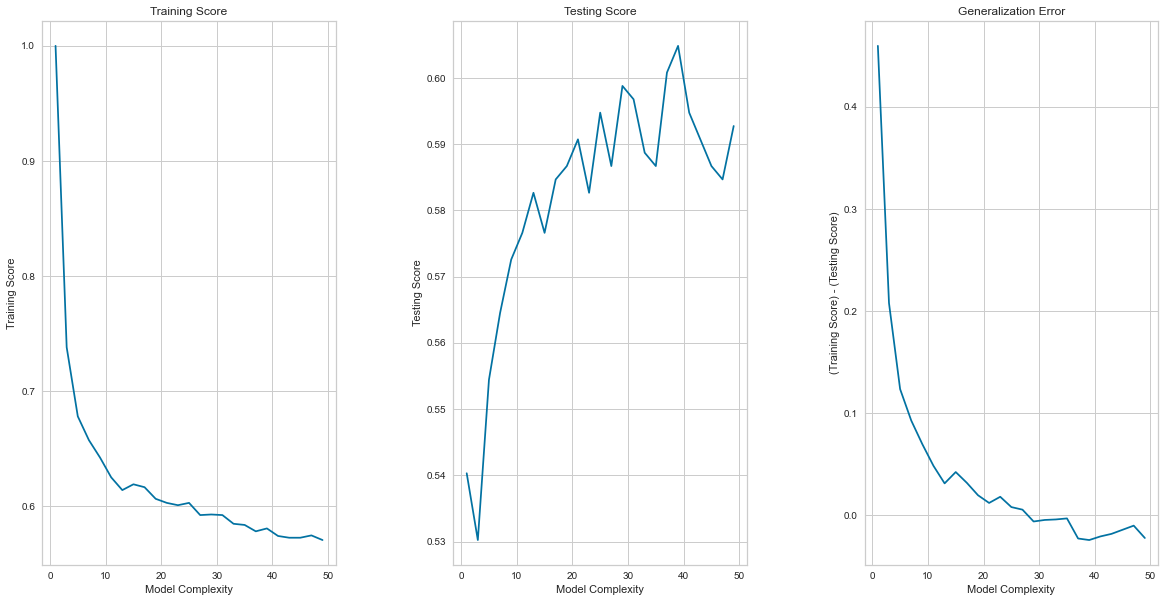

In [41]:
#Trying to determine a good k for KNN on new films only
X = df_newF_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_newF_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
max_depths = list(range(1,50,2))
train_scores = []
test_scores = []
for i in max_depths:
    model = KNeighborsClassifier(n_neighbors=i)

    model.fit(X_train, y_train)
    
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    
plt.subplots(figsize=(20,10))
plt.subplots_adjust(wspace=0.4)
plt.subplot(131)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(132)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')
plt.subplot(133)
plt.plot(max_depths, np.subtract(train_scores,test_scores))
plt.title("Generalization Error")
plt.xlabel('Model Complexity')
plt.ylabel('(Training Score) - (Testing Score)')
plt.show()

The optimal number of neighbors is 35


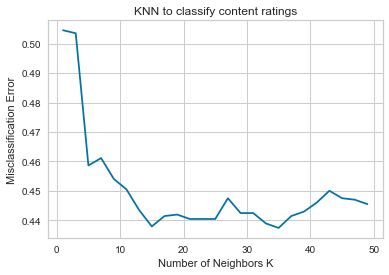

In [42]:
#Using 10fold CV to determine best k for new films only
X = df_newF_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_newF_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.title("KNN to classify content ratings")
plt.ylabel("Misclassification Error")
plt.show()

[[  0   3   7   1]
 [  0   7  55  15]
 [  0   6 122  65]
 [  0   0  53 162]]
training score: 0.5837537840565086
validation score: 0.5866935483870968
confusion matrix from kNN
[[  0   3   7   1]
 [  0   7  55  15]
 [  0   6 122  65]
 [  0   0  53 162]]


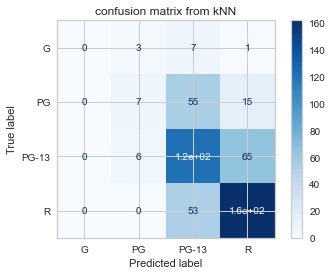

In [43]:
#Duplicate cell (see below)
X = df_newF_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_newF_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model=KNeighborsClassifier(n_neighbors = 35)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix(y_test,predictions,labels = ['G','PG','PG-13','R']))
print("training score:", model.score(X_train,y_train)) # how accurately did model capture training set relationship?
print("validation score:", model.score(X_test,y_test))
from sklearn.metrics import plot_confusion_matrix
classifier = model.fit(X_train,y_train)
disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['G','PG','PG-13','R'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
title = 'confusion matrix from kNN'
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

[[  0   3   7   1]
 [  0   7  55  15]
 [  0   6 122  65]
 [  0   0  53 162]]
training score: 0.5837537840565086
validation score: 0.5866935483870968
confusion matrix from kNN (After 2010)
[[  0   3   7   1]
 [  0   7  55  15]
 [  0   6 122  65]
 [  0   0  53 162]]


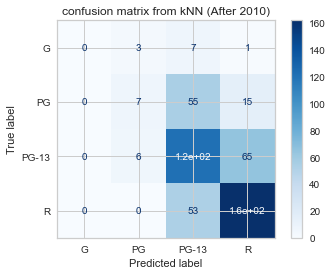

In [44]:
#Generating confusion matrix for opimal k of Knn on all films
X = df_newF_only4CR.drop(['movie_title','content_rating'],axis = 1)
X.fillna(X.mean(),inplace=True)
y= df_newF_only4CR['content_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)
model=KNeighborsClassifier(n_neighbors = 35)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,predictions)
print(confusion_matrix(y_test,predictions,labels = ['G','PG','PG-13','R']))
print("training score:", model.score(X_train,y_train)) # how accurately did model capture training set relationship?
print("validation score:", model.score(X_test,y_test))
from sklearn.metrics import plot_confusion_matrix
classifier = model.fit(X_train,y_train)
disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['G','PG','PG-13','R'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
title = 'confusion matrix from kNN (After 2010)'
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)



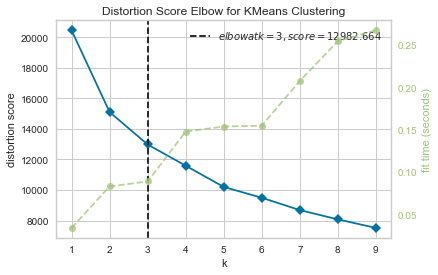

-12982.653480349893


In [45]:
#Clustering based on final features used in linear regression on all movies in the dataset.
#Conclusion: 
X = df_dummies.drop(['movie_facebook_likes_scaled','num_critic_for_reviews_scaled','movie_title','Approved','GP','M','NC-17','Not Rated','Passed','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','X','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
predictions = kmeans.predict(X)
print(kmeans.score(X))

In [46]:
centroids = kmeans.cluster_centers_
print(kmeans.labels_)
#print(centroids)

[2 2 2 ... 1 0 1]


-0.2586554227515913
-0.20579135818104985
1.744028794323356


C:\Users\gergo\AppData\Roaming\Python\Python36\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



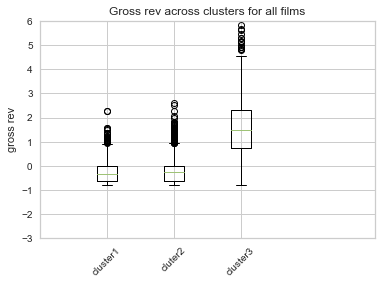

In [47]:
# ISOLATING GROS REVS FROM CLUSTERS AND MAKING BOXPLOTS for all Data
# df_dummies.iloc[(predictions==0)]['gross_scaled'].fillna(df_dummies.iloc[(predictions==0)]['gross_scaled'].mean(),inplace=True)
# df_dummies.iloc[(predictions==1)]['gross_scaled'].fillna(df_dummies.iloc[(predictions==1)]['gross_scaled'].mean(),inplace=True)
# df_dummies.iloc[(predictions==2)]['gross_scaled'].fillna(df_dummies.iloc[(predictions==2)]['gross_scaled'].mean(),inplace=True)
# bp = plt.boxplot([df_dummies[(predictions==0)]['gross_scaled'],df_dummies[(predictions==1)]['gross_scaled'],df_dummies[(predictions==2)]['gross_scaled']])
cluster1 = df_dummies[(predictions==0)]['gross_scaled']
cluster2 = df_dummies[(predictions==1)]['gross_scaled']
cluster3 = df_dummies[(predictions==2)]['gross_scaled']
print(cluster1.mean())
print(cluster2.mean())
print(cluster3.mean())
cluster1.fillna(cluster1.mean(),inplace=True)
cluster2.fillna(cluster2.mean(),inplace=True)
cluster3.fillna(cluster3.mean(),inplace=True)
bp = plt.boxplot([cluster1,cluster2,cluster3])
plt.title('Gross rev across clusters for all films')
plt.xticks([1,2,3],['cluster1','cluter2','cluster3'])
plt.xlim([0,5])
plt.ylim([-3,6])
plt.xticks(rotation=45)
plt.ylabel('gross rev')

plt.show()

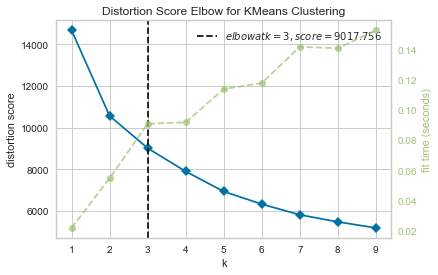

-9017.756479335607


In [48]:
#Elbow plot for k means on new films
X = newFilms.drop(['movie_facebook_likes_scaled','num_critic_for_reviews_scaled','movie_title','NC-17','Not Rated','TV-14','TV-G','TV-MA','TV-PG','TV-Y7','Unrated','unknown'],axis = 1)
X.fillna(X.mean(),inplace=True)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(X)
predictions1 = kmeans.predict(X)
print(kmeans.score(X))


-0.24482459591207484
-0.24798258970680956
1.7730608775582974


C:\Users\gergo\AppData\Roaming\Python\Python36\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



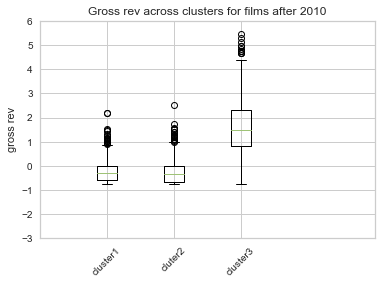

In [49]:
# ISOLATING GROS REVS FROM CLUSTERS AND MAKING BOXPLOTS for just new films
cluster1 = newFilms[(predictions1==0)]['gross_scaled']
cluster2 = newFilms[(predictions1==1)]['gross_scaled']
cluster3 = newFilms[(predictions1==2)]['gross_scaled']
print(cluster1.mean())
print(cluster2.mean())
print(cluster3.mean())
cluster1.fillna(cluster1.mean(),inplace=True)
cluster2.fillna(cluster2.mean(),inplace=True)
cluster3.fillna(cluster3.mean(),inplace=True)
bp = plt.boxplot([cluster1,cluster2,cluster3])
plt.title('Gross rev across clusters for films after 2010')
plt.xticks([1,2,3],['cluster1','cluter2','cluster3'])
plt.xlim([0,5])
plt.ylim([-3,6])
plt.xticks(rotation=45)
plt.figsize=(30,15)
plt.ylabel('gross rev')

plt.show()